In [2]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cse493g1/assignments/assignment2/'
FOLDERNAME = 'cse493g1/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cse493g1/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cse493g1/assignments/assignment2/cse493g1/datasets
/content/drive/My Drive/cse493g1/assignments/assignment2


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://courses.cs.washington.edu/courses/cse493g1/24wi/assignments/) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [3]:
import random
import numpy as np
from cse493g1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [4]:
from cse493g1.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cse493g1/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [5]:
from cse493g1.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed in Assignment 1 (copy and paste your code from Assignment 1 into the file `cse493g1/classifiers/linear_svm.py`), train SVMs on top of the features extracted above. This should achieve better results than training SVMs directly on top of raw pixels.

In [6]:
# Use the validation set to tune the learning rate and regularization strength

from cse493g1.classifiers.linear_classifier import LinearSVM

results = {}
best_val = -1
best_svm = None

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [2e-7, 5e-7, 8e-7]
regularization_strengths = [8e4, 5e4, 2e4, 7e3]
num_iters_val = 2000

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in learning_rates:
  for reg in regularization_strengths:
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=num_iters_val)
    y_pred_train = svm.predict(X_train_feats)
    y_pred_val = svm.predict(X_val_feats)
    acc_val = np.mean(y_val == y_pred_val)
    acc_train = np.mean(y_train == y_pred_train)
    results[(lr, reg)] = acc_train, acc_val
    if acc_val > best_val :
      best_val = acc_val
      best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)

lr 2.000000e-07 reg 7.000000e+03 train accuracy: 0.413224 val accuracy: 0.400000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.414571 val accuracy: 0.413000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.414673 val accuracy: 0.411000
lr 2.000000e-07 reg 8.000000e+04 train accuracy: 0.414000 val accuracy: 0.410000
lr 5.000000e-07 reg 7.000000e+03 train accuracy: 0.417367 val accuracy: 0.414000
lr 5.000000e-07 reg 2.000000e+04 train accuracy: 0.416878 val accuracy: 0.415000
lr 5.000000e-07 reg 5.000000e+04 train accuracy: 0.402878 val accuracy: 0.396000
lr 5.000000e-07 reg 8.000000e+04 train accuracy: 0.413163 val accuracy: 0.410000
lr 8.000000e-07 reg 7.000000e+03 train accuracy: 0.410898 val accuracy: 0.410000
lr 8.000000e-07 reg 2.000000e+04 train accuracy: 0.413694 val accuracy: 0.412000
lr 8.000000e-07 reg 5.000000e+04 train accuracy: 0.411082 val accuracy: 0.400000
lr 8.000000e-07 reg 8.000000e+04 train accuracy: 0.412796 val accuracy: 0.403000
best validation accuracy ach

In [7]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.424


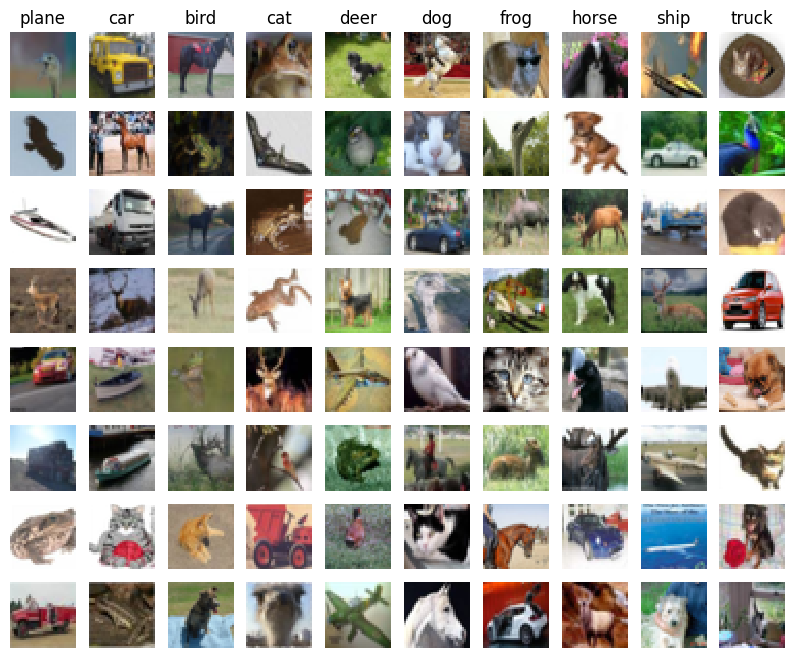

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$ In most cases, the misclassification results make sense. They can be categorized as the following :
1. Visually similar classes : Classes with similar shapes/structures/textures were misclassified as one another.
2. Completely Unrelated Classes : Linear SVMs are bad at representing non-linear decision boundaries since they essentially try to find linear decision boundaries in high dimensional space. This could be the reason that they predict completely unrelated classes as one another
3. Too much Importance given to Backgrounds : The SVM might focus too much on the background of an image rather than the object itself. For example, airplanes in a blue sky may be misclassified as ships due to the blue color



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels.

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [9]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [10]:
from cse493g1.classifiers.fc_net import TwoLayerNet
from cse493g1.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

data = {
    'X_train': X_train_feats,
    'y_train': y_train,
    'X_val': X_val_feats,
    'y_val': y_val,
    'X_test': X_test_feats,
    'y_test': y_test,
}

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

num_epochs = [5,7,9]
learning_rates = [8e-2, 1e-1, 5e-1, 8e-1]

best_val_acc = 0

for epoch in num_epochs:
  print("Number of epochs : " + str(epoch))
  for lr in learning_rates:
    print("Learning Rate : " + str(lr))
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    solver = Solver(net, data,
                      update_rule='sgd',
                      optim_config={
                        'learning_rate': lr,
                      },
                      lr_decay=0.95,
                      num_epochs=epoch, batch_size=200,
                      print_every=100)
    solver.train()
    if solver.best_val_acc > best_val_acc:
      best_net = net
      best_val_acc = solver.best_val_acc

print("Best Val Acc : " + str(best_val_acc))

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


Number of epochs : 5
Learning Rate : 0.08
(Iteration 1 / 1225) loss: 2.302592
(Epoch 0 / 5) train acc: 0.091000; val_acc: 0.088000
(Iteration 101 / 1225) loss: 2.280420
(Iteration 201 / 1225) loss: 1.935432
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.353000
(Iteration 301 / 1225) loss: 1.762230
(Iteration 401 / 1225) loss: 1.514206
(Epoch 2 / 5) train acc: 0.496000; val_acc: 0.476000
(Iteration 501 / 1225) loss: 1.548705
(Iteration 601 / 1225) loss: 1.364882
(Iteration 701 / 1225) loss: 1.477288
(Epoch 3 / 5) train acc: 0.528000; val_acc: 0.514000
(Iteration 801 / 1225) loss: 1.341147
(Iteration 901 / 1225) loss: 1.267766
(Epoch 4 / 5) train acc: 0.520000; val_acc: 0.507000
(Iteration 1001 / 1225) loss: 1.360957
(Iteration 1101 / 1225) loss: 1.217563
(Iteration 1201 / 1225) loss: 1.387530
(Epoch 5 / 5) train acc: 0.529000; val_acc: 0.529000
Learning Rate : 0.1
(Iteration 1 / 1225) loss: 2.302567
(Epoch 0 / 5) train acc: 0.093000; val_acc: 0.078000
(Iteration 101 / 1225) loss: 2.22907

In [11]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.582
